<a href="https://colab.research.google.com/github/Vladskoba/Portfolio/blob/main/Face%20age/Face_age.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Импорты

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from google.colab import drive
import zipfile
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50


# Проект "Определение возраста"

Ставится задача отпределить возраст человека на основе фотографии

**План работы**
* Загрузить данные
*   Провести исследовательский анализ
*   Выгрузить изображения из датасета для ознакомления
*   Обучение модели
* Итоговый вывод


## Загрузка данных

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
local_zip = '/content/drive/MyDrive/faces.zip'

In [4]:
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [5]:
os.listdir('/content/dataset')

['labels.csv', 'final_files']

In [6]:
labels = pd.read_csv('/content/dataset/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/content/dataset/final_files/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


# Исследование данных

In [7]:
labels.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


### Распределение возрастов объектов

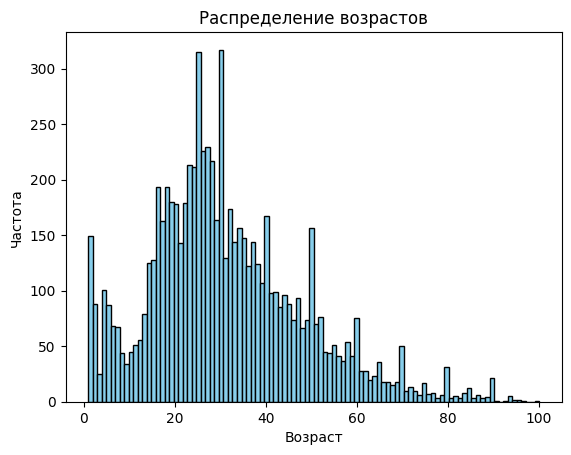

In [8]:
plt.hist(labels['real_age'], bins=100, color='skyblue', edgecolor='black')
plt.title('Распределение возрастов')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

### Вывод изображений

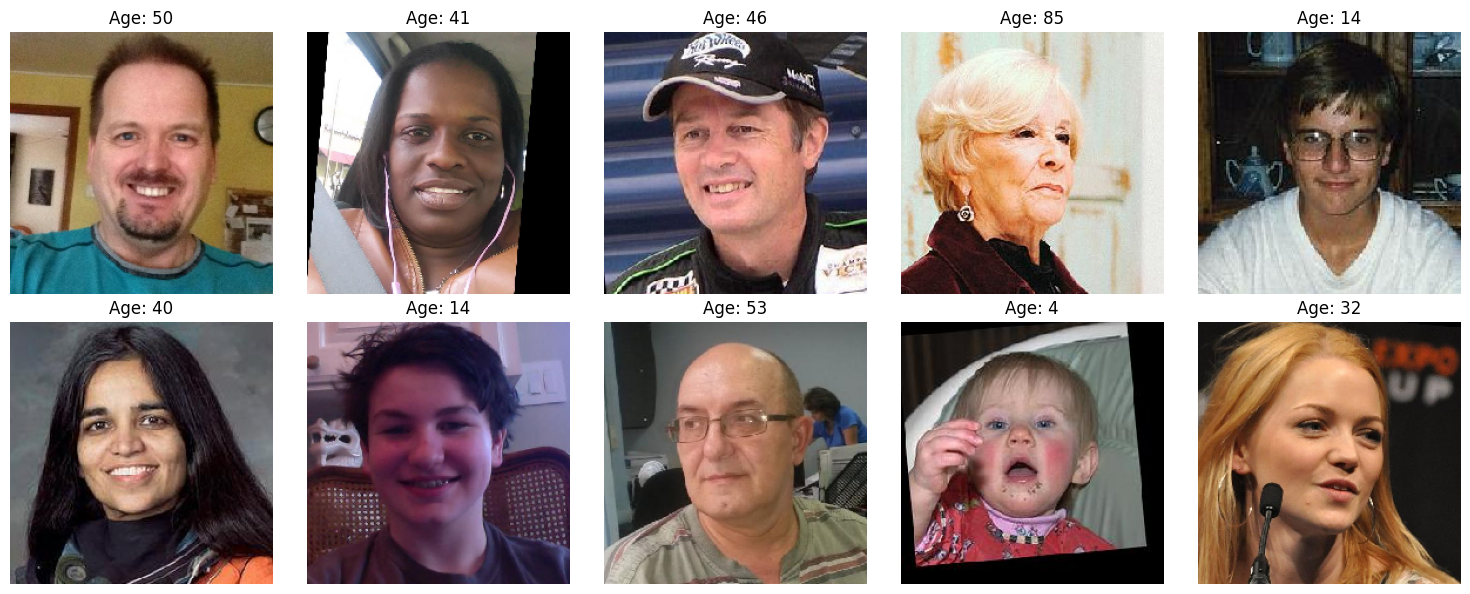

In [9]:
batch_images, batch_labels = train_gen_flow.next()

plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(batch_images[i])
    plt.title(f'Age: {batch_labels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Уникальные размеры изображений

In [10]:
image_sizes = set()
for image_path in labels['file_name']:
    image = Image.open('/content/dataset/final_files/final_files/' + image_path)
    image_sizes.add(image.size)

print("Уникальные размеры изображений в датасете:", image_sizes)

Уникальные размеры изображений в датасете: {(277, 277), (1108, 1108), (580, 580), (446, 500), (1159, 1159), (310, 310), (631, 631), (343, 344), (901, 900), (613, 613), (73, 74), (2293, 2293), (646, 646), (106, 107), (409, 410), (136, 135), (679, 679), (118, 117), (439, 438), (377, 377), (982, 982), (712, 712), (1000, 999), (151, 150), (184, 184), (410, 410), (443, 444), (475, 476), (454, 453), (217, 217), (505, 504), (206, 207), (999, 746), (250, 250), (538, 537), (509, 510), (815, 845), (797, 797), (520, 519), (207, 208), (779, 779), (527, 527), (239, 240), (251, 251), (1070, 1071), (830, 830), (2189, 2189), (240, 241), (812, 812), (284, 284), (863, 863), (302, 301), (317, 317), (47, 47), (335, 334), (911, 912), (350, 350), (1181, 1181), (929, 929), (80, 80), (944, 945), (383, 383), (1214, 1214), (1221, 1222), (146, 147), (125, 124), (416, 416), (675, 676), (176, 175), (114, 114), (1007, 1006), (158, 157), (726, 727), (449, 449), (737, 736), (708, 709), (209, 208), (996, 996), (147, 1

In [11]:
modes = []
for image_path in labels['file_name']:
    image = Image.open('/content/dataset/final_files/final_files/' + image_path)
    modes.append(image.mode)
modes_counts = pd.Series(modes).value_counts()
print(modes_counts)

RGB    7591
Name: count, dtype: int64


## Создание модели

### Тренировочный генератор

In [13]:
labels = pd.read_csv('/content/dataset/' + 'labels.csv')
train_datagen = ImageDataGenerator(
validation_split=0.25,
rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
dataframe=labels,
directory='/content/dataset/final_files/final_files',
x_col='file_name',
y_col='real_age',
target_size=(150, 150),
batch_size=16,
class_mode='raw',
subset='training',
seed=12345)

Found 5694 validated image filenames.


### Тестовый генератор

In [14]:
test_datagen = ImageDataGenerator(
validation_split=0.25,
rescale=1./255)

test_gen_flow = test_datagen.flow_from_dataframe(
dataframe=labels,
directory='/content/dataset/final_files/final_files',
x_col='file_name',
y_col='real_age',
target_size=(150, 150),
batch_size=16,
class_mode='raw',
subset='training',
seed=12345)

Found 5694 validated image filenames.


### Создание слоёв

In [15]:
optimizer = Adam(learning_rate=0.0001)
backbone = ResNet50(input_shape=(150, 150, 3),
                    weights='imagenet',
                    include_top=False)
model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='relu'))
model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

94765736/94765736 [==============================] - 0s 0us/step


### Обучение модели

In [16]:
steps_per_epoch = max(1, train_gen_flow.samples // train_gen_flow.batch_size)
validation_steps = max(1, test_gen_flow.samples // test_gen_flow.batch_size)

model.fit(train_gen_flow,
          epochs=30,
          validation_data=test_gen_flow,
              batch_size=32,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

Epoch 1/30
355/355 - 100s - loss: 227.5792 - mae: 10.9380 - val_loss: 617.3234 - val_mae: 19.4639 - 100s/epoch - 280ms/step
Epoch 2/30
355/355 - 59s - loss: 81.6665 - mae: 6.9059 - val_loss: 248.1017 - val_mae: 11.7258 - 59s/epoch - 166ms/step
Epoch 3/30
355/355 - 55s - loss: 47.7362 - mae: 5.3425 - val_loss: 39.0954 - val_mae: 4.8787 - 55s/epoch - 155ms/step
Epoch 4/30
355/355 - 60s - loss: 32.7298 - mae: 4.3861 - val_loss: 37.3624 - val_mae: 4.9083 - 60s/epoch - 168ms/step
Epoch 5/30
355/355 - 55s - loss: 22.9527 - mae: 3.6719 - val_loss: 41.7627 - val_mae: 5.3209 - 55s/epoch - 154ms/step
Epoch 6/30
355/355 - 54s - loss: 21.0262 - mae: 3.4902 - val_loss: 25.0521 - val_mae: 3.8542 - 54s/epoch - 153ms/step
Epoch 7/30
355/355 - 60s - loss: 17.4698 - mae: 3.1790 - val_loss: 22.4930 - val_mae: 3.7040 - 60s/epoch - 168ms/step
Epoch 8/30
355/355 - 54s - loss: 14.2230 - mae: 2.9062 - val_loss: 12.3545 - val_mae: 2.7048 - 54s/epoch - 153ms/step
Epoch 9/30
355/355 - 60s - loss: 12.6529 - mae: 

### Результат на тестовой выборке

In [17]:
test_loss, test_mae = model.evaluate(test_gen_flow, steps=validation_steps)
print(f"Test loss: {test_loss}")
print(f"Test MAE: {test_mae}")

355/355 [==============================] - 18s 49ms/step - loss: 4.3396 - mae: 1.5751
Test loss: 4.339605808258057
Test MAE: 1.575050711631775
